# Homework 6

## FINM 36700 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu


## HBS Case

### AQR_s Momentum Funds

---

# Section 1: The Momentum Product

*This section is not graded, and you do not need to submit your answers. But you are expected to consider these issues and be ready to discuss them.*

**1. What is novel about the AQR Momentum product under construction compared to the various momentum investment products already offered?**

<span style="color:red">__*Answer 1.1:*__</span>

- The AQR's Momentum product is a mutual fund, and thus any retail investors can invest.
- Two characterisitcs of mutual fund:
  1. Long-only: legally limited in their use of short positions and leverage
  2. Open-end: had to be ready to return capital at the end of the trading day to respond to investor redemptions


**2. Name three reasons the momentum investment product will not exactly track the momentum index (i.e., why the strategy will have tracking error).**

<span style="color:red">__*Answer 1.2:*__</span>

- *Transaction Costs*: The momentum index is a theoretical construct that assumes no transaction costs. In reality, transaction costs will be incurred when the fund buys and sells stocks to implement the strategy.

- *Trade period*: The find might not trade an entire position instantaneously, but rather over a period of time, to decrease transaction costs, but which might lead to tracking error. 

- *Whether to trade "boundary" stocks*: if a stock is part of the index, and in the following month it is barely out, and another stock is barely in, the fund might not necessarily trade the boundary stocks to avoid tansaaction costs, as the expected return of the two stocks might not be different enough to justify the transaction costs.

- *Tax implications*: it is going to change every month, because it is a state dependent variable in a dynamic optimization. 

**3. When constructing the momentum portfolio, AQR ranks stocks on their returns from month $t - 12$ through $t - 2$. Why don’t they include the $t - 1$ return in this ranking?**

<span style="color:red">__*Answer 1.3:*__</span>

- Evidence in Jegadeesh (1990) show that the winning/losing stocks between $t − 1$ to $t$ may show short-term reversal, so incorporating t-1 in the momentum strategy would hurt performance.



---

# Section 2: Investigating Momentum

In this section, we empirically investigate some concerns regarding AQR’s new momentum product.

On Canvas, find the data file, “momentum\_data.xlsx”.

- The first tab contains the momentum factor as an excess return: $\bar{r}^{\text{mom}}$.

- The second tab contains returns on portfolios corresponding to scored momentum deciles.
  - $r^{\text{mom}(1)}$ denotes the portfolio of stocks in the lowest momentum decile, the “losers” with the lowest past returns.
  - $r^{\text{mom}(10)}$ denotes the portfolio of stocks in the highest momentum decile.

- The third tab gives portfolios sorted by momentum and size.
  - $r^{\text{momSU}}$ denotes the portfolio of small stocks in the top 3 deciles of momentum scores.
  - $r^{\text{momBD}}$ denotes the portfolio of big stocks in the bottom 3 deciles of momentum scores.

Note that the Fama-French momentum return, $r^{\text{mom:FF}}$, given in the first tab, is constructed by FF as,

$$
\bar{r}^{\text{mom:FF}} = \frac{1}{2} \left( r^{\text{momBU}} + r^{\text{momSU}} \right) - \frac{1}{2} \left( r^{\text{momBD}} + r^{\text{momSD}} \right)
$$


In [1]:
# Import Libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime
from typing import Union, List, Callable

import warnings
warnings.filterwarnings("ignore")

pd.options.display.float_format = "{:,.4f}".format
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', 30)

import statsmodels.api as sm
from scipy.stats import t

import os
import sys

parent_path = os.path.dirname(os.getcwd()) # Get parent path (if using .ipynb file)
# parent_path = os.path.dirname(os.path.dirname(os.path.abspath(__file__))) # Get parent path (if using .py file)
os.chdir(parent_path) # Set parent path as working directory (for reading and writing files)
sys.path.insert(0, parent_path) # Add parent path to system path (for importing modules)

import utils.portfolio_management_functions as pm

In [2]:
# Check data in the file (sheets, columns, data):
INFILE = "data/momentum_data.xlsx"
try:
    pm.read_excel_default(INFILE, print_sheets = True)
except FileNotFoundError as e:
    print(f'{e}.\nCheck file in {parent_path}')

Sheet name: descriptions
Columns: Unnamed: 0, Name, Unit, Construction, Description
  Unnamed: 0    Name           Unit         Construction                                        Description
0        MKT  Market  Excess Return  Market-cap-weighted                                        US Equities
1        SMB    Size  Excess Return      Small Minus Big             Long small stocks and short big stocks
2        HML   Value  Excess Return       High Minus Low  Long value (high book-to-market) stocks and sh...
----------------------------------------------------------------------


Sheet name: factors (excess returns)
Columns: Date, MKT, SMB, HML
        Date     MKT     SMB     HML
0 1927-01-31 -0.0006 -0.0037  0.0454
1 1927-02-28  0.0418  0.0004  0.0294
2 1927-03-31  0.0013 -0.0165 -0.0261
----------------------------------------------------------------------


Sheet name: momentum (excess returns)
Columns: Date, UMD
        Date     UMD
0 1927-01-31  0.0036
1 1927-02-28 -0.0214
2 19

In [3]:
# Import data from the file:
description = pd.read_excel(INFILE, sheet_name='descriptions',index_col=0)
factors_returns = pd.read_excel(INFILE, sheet_name='factors (excess returns)',index_col=0)
momentum_returns = pd.read_excel(INFILE, sheet_name='momentum (excess returns)',index_col=0)
risk_free_rate = pd.read_excel(INFILE, sheet_name='risk-free rate',index_col=0)
mom_dec_port_tot_ret = pd.read_excel(INFILE, sheet_name='deciles (total returns)',index_col=0)
mom_size_port_tot_ret = pd.read_excel(INFILE, sheet_name='size_sorts (total returns)',index_col=0)

display(description)

,Name,Unit,Construction,Description
MKT,Market,Excess Return,Market-cap-weighted,US Equities
SMB,Size,Excess Return,Small Minus Big,Long small stocks and short big stocks
HML,Value,Excess Return,High Minus Low,Long value (high book-to-market) stocks and sh...
RF,Risk-free rate,Total Return,Tbills,NaN
SMALL LoPRIOR,Small Down,Total Return,Small Losers,Bottom 3 deciles and Small
SMALL HiPRIOR,Small Up,Total Return,Small Winners,Top 3 deciles and Small
BIG LoPRIOR,Big Down,Total Return,Big Losers,Bottom 3 deciles and Big
BIG HiPRIOR,Big Up,Total Return,Big Winners,Top 3 deciles and Big


In [4]:
print(mom_dec_port_tot_ret.head(3))
print()
print(mom_size_port_tot_ret.head(3))

            Lo PRIOR  PRIOR 2  PRIOR 3  PRIOR 4  PRIOR 5  PRIOR 6  PRIOR 7  PRIOR 8  PRIOR 9  Hi PRIOR
Date                                                                                                  
1927-01-31   -0.0332  -0.0446   0.0269  -0.0033  -0.0041   0.0097   0.0074   0.0036  -0.0041   -0.0024
1927-02-28    0.0753   0.0593   0.0825   0.0727   0.0322   0.0421   0.0283   0.0326   0.0420    0.0701
1927-03-31   -0.0323  -0.0301  -0.0392  -0.0477  -0.0048  -0.0242   0.0205   0.0041   0.0096    0.0547

            SMALL LoPRIOR  ME1 PRIOR2  SMALL HiPRIOR  BIG LoPRIOR  ME2 PRIOR2  BIG HiPRIOR
Date                                                                                      
1927-01-31         0.0008      0.0357         0.0040      -0.0040      0.0026       0.0000
1927-02-28         0.0701      0.0648         0.0551       0.0727      0.0380       0.0447
1927-03-31        -0.0346     -0.0288        -0.0206      -0.0357     -0.0018       0.0226


### 2.1. Is momentum still profitable?

The excess returns of lucrative trading strategies often disappear once the strategy is well-known. The first widely-cited paper on momentum was published in 1993. Have momentum returns or risk changed since then? The AQR case takes place at the end of 2008. Have momentum returns changed in 2009-2024?

Investigate by filling out the summary statistics below for the full-sample and three sub-samples.

#### (a) Using the data provided, fill in Table 1 with the appropriate stats for $\bar{r}^{\text{mom:FF}}$.

*Table 1: Momentum performance over time.*

| Subsample | mean | vol | Sharpe | skewness | corr. to $\bar{r}^m$ | corr. to $\bar{r}^w$ |
|-----------|------|-----|--------|----------|----------------------|-----------------------|
| 1927-2024 |      |     |        |          |                      |                       |
| 1927-1993 |      |     |        |          |                      |                       |
| 1994-2008 |      |     |        |          |                      |                       |
| 2009-2024 |      |     |        |          |                      |                       |

<span style="color:red">__*Answer 2.1 - (a)*__</span>

In [5]:
  # Calculate the factor returns statistics:
factors_returns_all = pd.concat([factors_returns, momentum_returns], axis=1)
momentum_performance_tf = pm.calc_returns_statistics(factors_returns_all,
                                    provided_excess_returns=True,
                                    annual_factor=12,
                                    correlations=['MKT', 'HML'],
                                    tail_risks=True,
                                    timeframes={
                                        "1927-2024": ["1927", "2024"],
                                        "1927-1992": ["1927", "1992"],
                                        "1993-2008": ["1993", "2008"],
                                        "2009-2024": ["2009", "2024"]

                                    },
                                    keep_columns=['Annualized Mean', 'Annualized Vol', 'Annualized Sharpe', 'Skewness'],
                                    keep_indexes=['UMD'])

momentum_performance_tf.index = [idx.replace('UMD (', '') for idx in momentum_performance_tf.index]
momentum_performance_tf.index = [idx.replace(')', '') for idx in momentum_performance_tf.index]
display(momentum_performance_tf)

,Annualized Mean,Annualized Vol,Annualized Sharpe,Skewness,MKT Correlation,HML Correlation
1927-2024,0.0753,0.1625,0.4635,-2.9905,-0.3443,-0.4064
1927-1992,0.0883,0.1607,0.5493,-3.8058,-0.3648,-0.5043
1993-2008,0.1109,0.1719,0.6455,-0.6161,-0.2253,-0.1019
2009-2024,-0.0151,0.1585,-0.0952,-2.6910,-0.3676,-0.3209


#### (b) Has momentum changed much over time, as seen through these subsample statistics?

<span style="color:red">__*Answer 2.1 (b)*__</span>

It doesn't change much in the most of the periods. But the momentum is showing negative return after 2009. It is reasonable stable between 1927 and 2008, and has been slightly negative since 2009. 


#### (c) Does this data support AQR’s argument that momentum is an important piece of the ideal portfolio? What if mean returns to momentum are in actuality near zero due to transaction costs — would there still be evidence here that momentum is valuable?

<span style="color:red">__*Answer 2.1 (c)*__</span>

Yes, It was definitely profitable at 2008 when AQR was considering to launch the momentum product. Also, the momentum has a low correlation with market and value factor, which makes it a good diversifier. Even if the mean return is near zero, the momentum is still valuable because of its low correlation with other factors. Notably, even though the return profile has changed, it has maintained lower correlations to the market and value factors. 


### 2.2. The case is about whether a long-only implementation of momentum is valuable.

Construct your own long-only implementation:

*(Note that we must subtract the risk-free rate to get the excess return of this portfolio, $\bar{r}^{\text{mom:U}}$.)*


$$
\bar{r}^{\text{mom:U:FF}} = \frac{1}{2} \left( r^{\text{momBU}} + r^{\text{momSU}} \right) - r^f
$$

Note that this is following the FF approach of treating big and small stocks separately. This would be very similar to a scaled version of,

$$
\bar{r}^{\text{mom:U}} = \frac{1}{3} \left( r^{\text{mom(8)}} + r^{\text{mom(9)}} + r^{\text{mom(10)}} \right) - r^f
$$

For the questions below, use the FF-style, $\bar{r}^{\text{mom:U:FF}}$.

#### (a) Fill out Table 2 for the data **in the period 1994-2024**.

*Table 2: Long-only momentum performance.*

| 1994-2024      | mean | vol | Sharpe | skew | corr. to $\bar{r}^m$ | corr. to $\bar{r}^w$ |
|----------------|------|-----|--------|------|-----------------------|-----------------------|
| Long-and-short, ($\bar{r}^{\text{mom:FF}}$) |      |     |        |      |                       |                       |
| Long-only ($\bar{r}^{\text{mom:U:FF}}$)     |      |     |        |      |                       |                       |



<span style="color:red">__*Answer 2.2 (a)*__</span>

In [6]:
momentum_returns_long_only = pd.DataFrame({'U (Long Only)': ((mom_size_port_tot_ret['BIG HiPRIOR'] + mom_size_port_tot_ret['SMALL HiPRIOR'])/2 - risk_free_rate['RF'])})
    
  # Calculate the factor returns statistics:
returns_temp = pd.concat([factors_returns, momentum_returns, momentum_returns_long_only], axis=1)
returns_temp = returns_temp.loc['1994':]
returns_temp.columns = [col.replace('UMD', 'UMD (Long-Short)') for col in returns_temp.columns]

momentum_performance_lo_vs_ls = pm.calc_returns_statistics(returns=returns_temp,
                                                provided_excess_returns=True,
                                                annual_factor=12,
                                                correlations=['MKT', 'HML'],
                                                tail_risks=True,
                                                keep_columns=['Annualized Mean', 'Annualized Vol', 'Annualized Sharpe', 'Skewness'],
                                                keep_indexes=['UMD (Long-Short)', 'U (Long Only)'])

display(momentum_performance_lo_vs_ls)


,Annualized Mean,Annualized Vol,Annualized Sharpe,Skewness,MKT Correlation,HML Correlation
UMD (Long-Short),0.0432,0.1677,0.2575,-1.4460,-0.3062,-0.2152
U (Long Only),0.1172,0.1784,0.6569,-0.4448,0.9036,-0.1190



#### (b) Is long-only momentum as attractive as long-short momentum with respect to mean, volatility, and Sharpe Ratio?

<span style="color:red">__*Answer 2.2 (b)*__</span>

Yes, long-only looks even more attractive than long-short momentum. The mean return is higher, while the volatility is similar. Sharpe ratio is higher as well.


#### (c) Is long-only momentum as diversifying as long-short momentum with respect to market and value premia?


<span style="color:red">__*Answer 2.2 (c)*__</span>

No, the long-only momentum portfolio has 90% of correlation with market, whereas the long-short momentum portfolio has -31% of correlation with market. This is because the long-only momentum portfolio is still exposed to market risk. Therefore, it does not diversify at all with respect to the market. However, it still has a low correlation with the value factor, which is a good diversifier.


#### (d) Show a plot of the cumulative product of $1 + \bar{r}^{\text{mom:FF}}$ and $1 + \bar{r}^{\text{mom:U:FF}}$ over the 1994-2024 subsample.²
This is not quite a cumulative return given that these are excess returns, which is why we must add 1 before taking the cumulative product.

<span style="color:red">__*Answer 2.2 (d)*__</span>



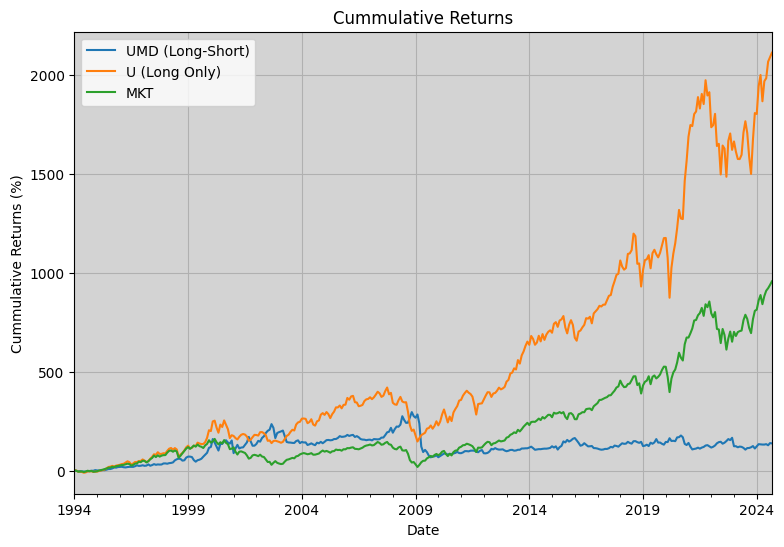

In [7]:
pm.calc_cummulative_returns(returns_temp[['UMD (Long-Short)', 'U (Long Only)', 'MKT']], fig_size=6)

### 2.3. Is momentum just data mining, or is it a robust strategy?

Assess how sensitive the threshold for the “winners” and “losers” is in the results. Specifically, we compare three constructions:

- **Long the top 1 decile and short the bottom 1 decile:**

  $$
  \bar{r}^{\text{momD1}} = r^{\text{mom}(10)} - r^{\text{mom}(1)}
  $$

- **Long the top 3 deciles and short the bottom 3 deciles:**

  $$
  \bar{r}^{\text{momD3}} = \frac{1}{3} \left( r^{\text{mom}(8)} + r^{\text{mom}(9)} + r^{\text{mom}(10)} \right) - \frac{1}{3} \left( r^{\text{mom}(1)} + r^{\text{mom}(2)} + r^{\text{mom}(3)} \right)
  $$

  which simplifies to

  $$
  = \frac{1}{3} \sum_{k=8}^{10} r^{\text{mom}(k)} - \frac{1}{3} \sum_{k=1}^{3} r^{\text{mom}(k)}
  $$

- **Long the top 5 deciles and short the bottom 5 deciles:**

  $$
  \bar{r}^{\text{momD5}} = \frac{1}{5} \sum_{k=6}^{10} r^{\text{mom}(k)} - \frac{1}{5} \sum_{k=1}^{5} r^{\text{mom}(k)}
  $$

---

#### (a) Compare all three constructions (in the full-sample period) by filling out the stats in the table below for the **period 1994-2024**.

*Table 3: Robustness of momentum construction.*

| 1994-2024 | mean | vol | Sharpe | skewness | corr. to $\bar{r}^m$ | corr. to $\bar{r}^w$ |
|-----------|------|-----|--------|----------|-----------------------|-----------------------|
| $\bar{r}^{\text{momD1}}$ |      |     |        |          |                       |                       |
| $\bar{r}^{\text{momD3}}$ |      |     |        |          |                       |                       |
| $\bar{r}^{\text{momD5}}$ |      |     |        |          |                       |                       |


<span style="color:red">__*Answer 2.3 (a)*__</span>

In [8]:
mom_dec_port_tot_ret.iloc[:, -5]

Date
1927-01-31    0.0097
1927-02-28    0.0421
1927-03-31   -0.0242
1927-04-30   -0.0005
1927-05-31    0.0580
               ...  
2024-05-31    0.0354
2024-06-30    0.0300
2024-07-31    0.0409
2024-08-31    0.0339
2024-09-30    0.0198
Name: PRIOR 6, Length: 1173, dtype: float64

In [9]:
momentum_returns_dec_port = pd.DataFrame({'UMD_D1': mom_dec_port_tot_ret.iloc[:, -1:].mean(axis=1) - mom_dec_port_tot_ret.iloc[:, :1].mean(axis=1),
                                          'UMD_D3': mom_dec_port_tot_ret.iloc[:, -3:].mean(axis=1) - mom_dec_port_tot_ret.iloc[:, :3].mean(axis=1),
                                          'UMD_D5': mom_dec_port_tot_ret.iloc[:, -5:].mean(axis=1) - mom_dec_port_tot_ret.iloc[:, :5].mean(axis=1)})
    
  # Calculate the factor returns statistics:
returns_temp = pd.concat([factors_returns, momentum_returns, momentum_returns_dec_port], axis=1)
returns_temp = returns_temp.loc['1994':]

momentum_performance_dec = pm.calc_returns_statistics(returns=returns_temp,
                                                provided_excess_returns=True,
                                                annual_factor=12,
                                                correlations=['MKT', 'HML'],
                                                tail_risks=True,
                                                keep_columns=['Annualized Mean', 'Annualized Vol', 'Annualized Sharpe', 'Skewness'],
                                                keep_indexes=['UMD_D1', 'UMD_D3', 'UMD_D5', 'UMD'])

display(momentum_performance_dec)

,Annualized Mean,Annualized Vol,Annualized Sharpe,Skewness,MKT Correlation,HML Correlation
UMD,0.0432,0.1677,0.2575,-1.4460,-0.3062,-0.2152
UMD_D1,0.0820,0.2990,0.2742,-1.3046,-0.3197,-0.2335
UMD_D3,0.0286,0.1934,0.1476,-1.3450,-0.3617,-0.2115
UMD_D5,0.0164,0.1340,0.1225,-1.4159,-0.3486,-0.2122


#### (b) Do the tradeoffs between the 1-decile, 3-decile, and 5-decile constructions line up with the theoretical tradeoffs we discussed in the lecture?

<span style="color:red">__*Answer 2.3 (b)*__</span>

Yes, we can see long-short portfolio with higher threshold of decile has higher return, but also higher volatility.


#### (c) Should AQR’s retail product consider using a 1-decile or 5-decile construction?

<span style="color:red">__*Answer 2.3 (c)*__</span>

I would recommend 1-decile, as it has higher sharpe, but can also see the argument for a 5 decile construction due to likely lower turnover (and therefore lower fees for investors).

#### (d) Does $\bar{r}^{\text{momD3}}$ have similar stats to the Fama-French construction in (1)? Recall that construction is also a 3-decile, long-short construction, but it is segmented for small and large stocks. Compare the middle row of Table 3 with the top row of Table 2.

<span style="color:red">__*Answer 2.3 (d)*__</span>

They are similar, but Fama-French construction has higher return and lower volatility, resulting with higher sharpe ratio. Fama-French construction allows balance between small and large stocks, whereas top 3 deciles construction could be biased towards either small or large stocks.


### 2.4. Does implementing momentum require trading lots of small stocks—thus causing even larger trading costs?

For regulatory and liquidity reasons, AQR is particularly interested in using larger stocks for their momentum baskets. (Though they will launch one product that focuses on medium-sized stocks.)

Use the data provided on both small-stock “winners”, $r^{\text{momSU}}_t$, and small-stock “losers”, $r^{\text{momSD}}_t$, to construct a small-stock momentum portfolio,

$$
r^{\text{momS}}_t = r^{\text{momSU}}_t - r^{\text{momSD}}_t
$$

Similarly, use the data provided to construct a big-stock momentum portfolio,

$$
r^{\text{momB}}_t = r^{\text{momBU}}_t - r^{\text{momBD}}_t
$$

#### (a) Fill out Table 4 over the sample 1994-2024.

*Table 4: Momentum of small and big stocks.*

| 1994-2024          | mean | vol | Sharpe | skewness | corr. to $\bar{r}[m]$ |
|--------------------|------|-----|--------|----------|-----------------------|
| All stocks, $\bar{r}^{\text{mom:FP}}$ |      |     |        |          |                       |
| Small stocks $r^{\text{momS}}$       |      |     |        |          |                       |
| Large stocks $r^{\text{momB}}$       |      |     |        |          |                       |



<span style="color:red">__*Answer 2.4 (a)*__</span>

In [10]:
momentum_returns_size_port = pd.DataFrame({'UMD_S': (mom_size_port_tot_ret['SMALL HiPRIOR'] - mom_size_port_tot_ret['SMALL LoPRIOR']),
                                          'UMD_B': (mom_size_port_tot_ret['BIG HiPRIOR'] - mom_size_port_tot_ret['BIG LoPRIOR'])
                                          })
    
  # Calculate the factor returns statistics:
returns_temp = pd.concat([factors_returns, momentum_returns, momentum_returns_size_port], axis=1)
returns_temp = returns_temp.loc['1994':]

momentum_performance_dec = pm.calc_returns_statistics(returns=returns_temp,
                                                provided_excess_returns=True,
                                                annual_factor=12,
                                                correlations=['MKT', 'HML'],
                                                tail_risks=True,
                                                keep_columns=['Annualized Mean', 'Annualized Vol', 'Annualized Sharpe', 'Skewness'],
                                                keep_indexes=['UMD_S', 'UMD_B', 'UMD'])

display(momentum_performance_dec)

,Annualized Mean,Annualized Vol,Annualized Sharpe,Skewness,MKT Correlation,HML Correlation
UMD,0.0432,0.1677,0.2575,-1.4460,-0.3062,-0.2152
UMD_S,0.0632,0.1696,0.3726,-1.7636,-0.3040,-0.1485
UMD_B,0.0232,0.1825,0.1270,-0.8791,-0.2802,-0.2575


#### (b) Is the attractiveness of the momentum strategy mostly driven by the small stocks? That is, does a momentum strategy in large stocks still deliver excess returns at comparable risk?

<span style="color:red">__*Answer 2.4 (b)*__</span>

Yes, the small stock momentum portfolio has almost 3 time higher sharpe ratio than the large stock momentum portfolio. Still, the large stock momentum portfolio delivers positive excess return.

### 5. In conclusion,


#### what is your assessment of the AQR retail product? Is it capturing the important features of the Fama-French construction of momentum? Would you suggest any modifications?

<span style="color:red">__*Answer 2.5*__</span>

- AQR's retail product uses a long only approach which leads to a higher correlation with the Market and has less diversification benefits compared to the benchmark index or Fama-French momentum factor.
- Quarterly rebalancing might make the portfolio diverge from the benchmark index and Fama-French momentum factor.


---

# Section 3: Barnstable’s Analysis
This section is not graded, and you do not need to submit your answers.  
*We may discuss these problems later, but they will not be covered in Midterm 2.*

#### 1. Barnstable’s Philosophy
  - **(a)** What has Barnstable’s investment strategy been in the past?
  - **(b)** Explain the logic behind their view that stocks are safer in the long run.
  - **(c)** What assumptions underly Barnstable’s belief in the long-run safety of stocks?


<span style="color:red">__*Answer 3.1 (a)*__</span>

They believed that in the long-run, stocks would outperform bonds and treasuries. They has a 40% allocation to the S&P 500, 30% to actively managed US stocks, and 30% to actively managed international stocks.


<span style="color:red">__*Answer 3.1 (b)*__</span>

Law of large numbers (time diversification): if each day is like a coin-flip with a positive expected value, then the more days you have, the more likely you are to make money. Aditionally, because of being "serially" uncorrelated, the movements cancel out. And your sharpe ratio increases with time.


<span style="color:red">__*Answer 3.1 (c)*__</span>

Independence of returns, and that the expected return is positive.


#### 2. Two Proposals
  - **(a)** Describe the two proposals Barnstable is considering for how to take advantage of their view regarding the long-run safety of stocks.
  - **(b)** How is the trust different from simply shorting the risk-free rate to take a levered position in stocks?
  - **(c)** Do these proposals take the same bet on long-run stock performance? In what outcomes will they have different returns?
  - **(d)** Do the two proposals differ in their risk?


<span style="color:red">__*Answer 3.2 (a)*__</span>

1. Selling puts on the S&P 500 index, which were at a premium (due to vol skew).
2. Selling shares on a pool of S&P 500 stocks, where (1) class of shares would return the minimum of the S&P return and 6%, and (2) would return whatever was left over from (1). They can then sell (1) and keep (2).


<span style="color:red">__*Answer 3.2 (b)*__</span>



<span style="color:red">__*Answer 3.2 (c)*__</span>

1. If the S&P 500 goes up, then (1) is strictly better than (2). The reason being that (2) is always capped at return - 6%, whereas (1) is not capped, and is in-fact boosted by the premium from the put.
2. If S&P 500 goes down, the (1) is worse than (2), since you're also short puts in addition to being long the S&P 500.



<span style="color:red">__*Answer 3.2 (d)*__</span>

I would say (1) is probably riskier than (2), due to amplified downside risk.



#### 3. Do you recommend a direct investment in the S&P, the trust or the puts?

<span style="color:red">__*Answer 3.3*__</span>


If Barnstable truly believes that the S&P will go up, and the probability of selling puts is that low, then yes, selling the puts doubles-down on their investment philosophy. However, just buying the S&P 500 is less risky and you are getting *that* much premium from selling the puts, so it is the best option.

The trust is some concoction dreamed up by a banker to collect fees, and is a terrible idea.

For readers of Money Stuff, the second proposal is something like:

![image](etf_cap.png)




---

# Section 4: Estimating Underperformance


### Data

- Use the returns on the S&P 500 ($r^m$) and 1-month T-bills, ($r^f$) provided in  
  **"barnstable.analysis.data.xlsx"**.

- Barnstable’s estimates of mean and volatility are based on the subsample of 1965 to 1999.

- We consider this subsample, as well as 2000-2024, as well as the full sample of 1926-2024.

- We only have data through part of 2024, but no adjustment is needed for the fact that you have only the partial year; just use what you have.

In [11]:
# Check data in the file (sheets, columns, data):
INFILE = "data/barnstable_analysis_data.xlsx"
try:
    pm.read_excel_default(INFILE, print_sheets = True)
except FileNotFoundError as e:
    print(f'{e}.\nCheck file in {parent_path}')

Sheet name: descriptions
Columns: Unnamed: 0, Description
  Unnamed: 0               Description
0        SPX              S&P500 Index
1       TB1M  Treasury Bill (1M) Index
----------------------------------------------------------------------


Sheet name: data
Columns: date, SPX, TB1M
        date     SPX   TB1M
0 1926-01-30 -0.0018 0.0031
1 1926-02-27 -0.0333 0.0026
2 1926-03-31 -0.0577 0.0026
----------------------------------------------------------------------




In [12]:
# Import data from the file:
description = pd.read_excel(INFILE, sheet_name='descriptions',index_col=0)
returns = pd.read_excel(INFILE, sheet_name='data',index_col=0)

returns = returns.assign(SPX_excess = returns['SPX'] - returns['TB1M'])
returns_log = np.log(1 + returns)


### 4.1. Summary Statistics

#### (a) Report the following (annualized) statistics.

$$
\begin{array}{|c|c|c|c|c|}
\hline
& \text{1965-1999} & \text{2000-2024} & \text{1926-2024} \\
& \text{mean} & \text{vol} & \text{mean} & \text{vol} \\
\hline
r^m & & & & \\
\tilde{r}^m & & & & \\
r^f & & & & \\
\hline
\text{logs} & & & & \\
r^m & & & & \\
\tilde{r}^m & & & & \\
r^f & & & & \\
\hline
\end{array}
$$


<span style="color:red">__*Answer 4.1 - (a)*__</span>

In [13]:
agg_years = [(1965, 1999), (2000, 2024), (1926, 2024)]
def calc_analytics_by_year(data, agg_years):
    res = []
    for y in agg_years:
        sub = data.loc[str(y[0]):str(y[1])]
        res.append({'mean': sub.mean() * 12, 'vol': sub.std() * np.sqrt(12)})
    return pd.DataFrame(res, index = [f'{i[0]} - {i[1]}' for i in agg_years]).stack()

sum_stats = returns.apply(calc_analytics_by_year, agg_years = agg_years).T
log_sum_stats = np.log(1 + returns).apply(calc_analytics_by_year, agg_years = agg_years).T

returns_stats = pd.concat([sum_stats, log_sum_stats])
returns_stats.index = pd.MultiIndex.from_product([['linear_returns','log_returns'], sum_stats.index.to_list()])
returns_stats.style.format('{:,.2%}')

#### (b) Comment on how the full-sample return stats compare to the sub-sample stats. Comment on how the level stats compare to the log stats.

<span style="color:red">__*Answer 4.1 - (b)*__</span>



### 2. Recall the following...

- If $x \sim \mathcal{N}(\mu_x, \sigma_x^2)$, then

$$
\Pr[x < \ell] = \Phi_N(L)
$$

where

$$
L = \frac{c - \mu_x}{\sigma_x}
$$

with $\Phi_N$ denoting the standard normal cumulative distribution function (cdf).

- Remember that cumulative log returns are simply the sum of the single-period log returns:

$$
r_{t,t+h}^m \equiv \sum_{i=1}^{h} r_{t+i}^m
$$

- It will be convenient to use and denote sample averages. We use the following notation for an $h$-period average ending at time $t + h$:

$$
\bar{r}_{t,t+h}^m = \frac{1}{h} \sum_{i=1}^{h} r_{t+i}^m
$$

Calculate the probability that the cumulative market return will fall short of the cumulative risk-free return:

$$
\Pr \left[ R_{t,t+h}^m < R_{t,t+h}^f \right] \tag{2}
$$

To analyze this analytically, convert the probability statement above to a probability statement about mean log returns.

#### (a) Calculate (2) using the subsample 1965-1999. Report the precise probability for $h = 15$ and $h = 30$ years. Plot the probability as a function of the investment horizon, $h$, for $0 < h \leq 30$ years.

<span style="color:red">__*Answer 4.2*__</span>

SPX underperforming RF in the next 15 years after 1999: 7.16%
SPX underperforming RF in the next 30 years after 1999: 1.92%


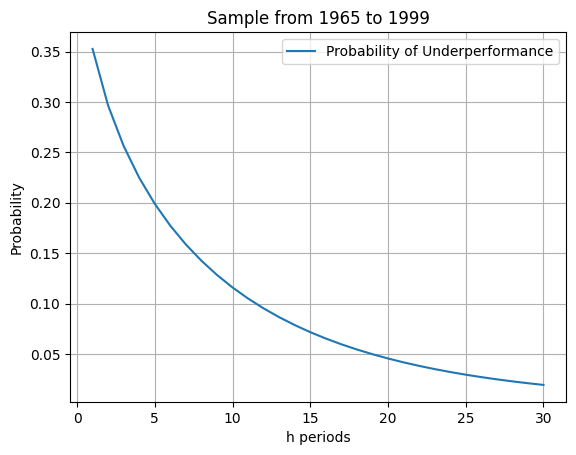

In [14]:
from scipy.stats import norm
def prob_shortfall(mu_return, sigma_return, h):
    threshold_h = 0 - h*mu_return
    sigma_h = np.sqrt(h) * sigma_return
    return norm.cdf(threshold_h/sigma_h)

mu_excess, sigma_excess = returns_stats['1965 - 1999'].loc[('log_returns', 'SPX_excess')] # SPX excess returns distribution (assuming normality)


print(f'SPX underperforming RF in the next 15 years after 1999: {prob_shortfall(mu_return=mu_excess, sigma_return=sigma_excess, h=15):,.2%}')

print(f'SPX underperforming RF in the next 30 years after 1999: {prob_shortfall(mu_return=mu_excess, sigma_return=sigma_excess, h=30):,.2%}')

h = np.arange(30) + 1
probs = pd.DataFrame([prob_shortfall(mu_excess, sigma_excess, x) for x in h], columns=['Probability of Underperformance'], index = h)
probs.plot(title = 'Sample from 1965 to 1999', ylabel = 'Probability', xlabel = 'h periods', grid=True)
plt.show()

### 3.

#### Use the sample 1965-2024 to reconsider the 30-year probability. As of the end of 2024, calculate the probability of the stock return underperforming the risk-free rate over the next 30 years. That is, $R_{t,t+h}^m$ underperforming $R_{t,t+h}^f$ for $0 < h \leq 30$.

<span style="color:red">__*Answer 4.3*__</span>

SPX underperforming RF in the next 30 years after 2024: 1.94%


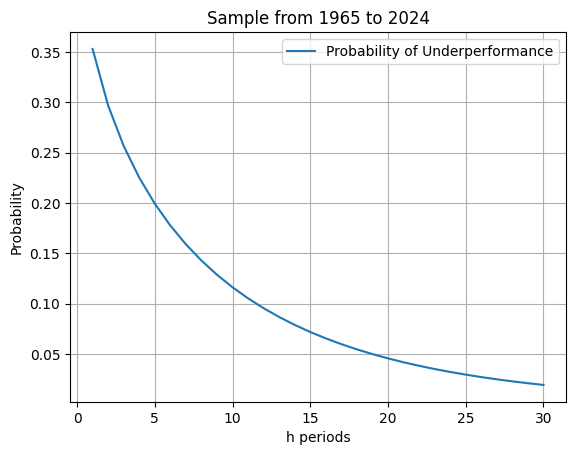

In [15]:
mu_excess = np.log(1+returns.loc['1965':'2024', 'SPX_excess']).mean() * 12
sigma_excess = np.log(1+returns.loc['1965':'2024', 'SPX_excess']).std() * np.sqrt(12)

print(f'SPX underperforming RF in the next 30 years after 2024: {prob_shortfall(mu_return=mu_excess, sigma_return=sigma_excess, h=30):,.2%}')

h = np.arange(30) + 1

probs_shortall = pd.DataFrame([prob_shortfall(mu_excess, sigma_excess, x) for x in h], columns=['Probability of Underperformance'], index = h)
probs_shortall.plot(title = 'Sample from 1965 to 2024', ylabel = 'Probability', xlabel = 'h periods', grid=True)
plt.show()


#### 4.

#### Let’s consider how things turned out relative to Barnstable’s 1999 expectations. What was the probability (based on the 1999 estimate of $\mu$), that the 25-year market return, $R_{t,t+25}^m$, would be smaller than that realized in 2000-2024? Note that we are asking about the market return, not the excess market return. Continue using the 1965-1999 sample standard deviation for $\sigma$.

<span style="color:red">__*Answer 4.4*__</span>

In [16]:
returns_stats[('1965 - 1999', 'mean')].loc[('log_returns', 'SPX')]

0.1176000182700086

In [17]:
mu_excess = returns_stats[('1965 - 1999', 'mean')].loc[('log_returns', 'SPX')] - returns_stats[('2000 - 2024', 'mean')].loc[('log_returns', 'SPX')]
sigma = returns_stats[('1965 - 1999', 'vol')].loc[('log_returns', 'SPX')]

print(f"Expected SPX return in 2000-2024: {returns_stats[('1965 - 1999', 'mean')].loc[('log_returns', 'SPX')]:.2%}")
print(f"Realized SPX return in 2000-2024: {returns_stats[('2000 - 2024', 'mean')].loc[('log_returns', 'SPX')]:.2%}")

print(f"\nProbability of underperformance in 2000-2024: {prob_shortfall(mu_excess, sigma, 25):,.2%}")

Expected SPX return in 2000-2024: 11.76%
Realized SPX return in 2000-2024: 7.53%

Probability of underperformance in 2000-2024: 7.85%
